## Gait Video Project
### Ablation Study on Cross generalization framework with Traditional ML models only 
* We will explore the performance of using feet coordinates only (merged from both front and side camera views), feet + ankle coordinates (merged from both front and side camera views), feet + ankle (merged from both front and side camera views) + knee (from the single front camera view) coordinates and all (feet + ankle (merged from both front and side camera views) + knee + hip (from the single front camera view)) coordinates on the traditional ML models.
* In our main traditional models, total 91 features (including the frame count and 90 CoV, range and asymmetry of the body coordinate features) were used.

In [15]:
from importlib import reload
from ml_utils.imports import *

from ml_utils import cross_gen_traditionalML
reload(cross_gen_traditionalML)
from ml_utils.cross_gen_traditionalML import extract_train_test_common_PIDs, compute_train_test_indices_split
from ml_utils.cross_gen_traditionalML import models, design, run_ml_models
from ast import literal_eval
import xgboost, itertools

In [16]:
path = 'C:\\Users\\Rachneet Kaur\\Box\\Gait Video Project\\GaitVideoData\\video\\'
data_path = path+'traditional_methods_dataframe.csv'
results_path = 'C:\\Users\\Rachneet Kaur\\Box\Gait Video Project\\AblationResults\\ML\\'

data = pd.read_csv(data_path, index_col= 0)
display(data.head())
        
#Whether to save the results (confusion matrices and RoC plots) or not 
save_results = True 

,key,cohort,trial,scenario,video,PID,stride_number,frame_count,label,right hip-x-CoV,...,ankle-z-asymmetry,heel-x-asymmetry,heel-y-asymmetry,heel-z-asymmetry,toe 1-x-asymmetry,toe 1-y-asymmetry,toe 1-z-asymmetry,toe 2-x-asymmetry,toe 2-y-asymmetry,toe 2-z-asymmetry
0,GVS_212_T_T1_1,HOA,BW,SLWT,GVS_212_T_T1,212,1,46,0,0.046077,...,14.426173,3.407379,10.662441,0.830365,0.502570,31.450487,8.644012,5.236678,31.182183,8.215725
1,GVS_212_T_T1_2,HOA,BW,SLWT,GVS_212_T_T1,212,2,39,0,0.021528,...,1.360847,5.155307,11.363806,4.333776,1.025647,28.266400,2.671081,6.678294,15.058825,4.903579
2,GVS_212_T_T1_3,HOA,BW,SLWT,GVS_212_T_T1,212,3,56,0,0.034394,...,1.341021,8.625363,7.159495,3.366152,1.759968,17.545787,5.921325,8.243491,9.578638,3.008162
3,GVS_212_T_T1_4,HOA,BW,SLWT,GVS_212_T_T1,212,4,53,0,0.028511,...,2.375934,6.728268,0.098235,0.999027,0.541911,7.843339,4.279617,0.748023,19.471731,5.086056
4,GVS_212_T_T1_5,HOA,BW,SLWT,GVS_212_T_T1,212,5,44,0,0.025213,...,8.525816,1.775282,0.033210,9.166863,1.354601,6.674183,8.479480,4.373622,0.315168,11.795593


In [17]:
#We are training on some subjects of trial W and testing on separate remaining subjects of trial WT
train_framework = 'W'
test_framework = 'WT'

#Extracting the list of PIDs/subjects that are only included in the training set, only included in the testing set 
#and common PIDs in both training and testing sets 
train_pids, test_pids, common_pids = extract_train_test_common_PIDs(data, train_framework, test_framework)
design()


Original number of subjects in training task W are: 32
Original number of subjects in testing task WT are: 26
Common number of subjects across train and test frameworks:  25
Common subjects across train and test frameworks:  [404, 405, 406, 407, 408, 409, 410, 411, 310, 311, 313, 314, 318, 320, 321, 322, 323, 212, 213, 214, 215, 216, 217, 218, 219]
Number of subjects only in training framework:  7
Subjects only in training framework:  [102, 112, 113, 115, 312, 123, 124]
Number of subjects only in test framework:  1
Subjects only in test framework:  [403]
******************************************


In [18]:
#Trial W for training 
trialW = data[data['scenario']==train_framework] #Full trial W with all 32 subjects 
#Trial WT for testing 
trialWT = data[data['scenario']==test_framework] #Full trial WT with all 26 subjects 

#Full training data stats 
print ('Number of subjects in trial W in each cohort:\n', trialW.groupby('PID').first()['cohort'].value_counts())
print('Strides in complete training set: ', len(trialW))
print ('HOA, MS and PD strides in complete training set:\n', trialW['cohort'].value_counts())
design()

#Full testing data stats 
print ('Number of subjects in trial WT in each cohort:\n', trialWT.groupby('PID').first()['cohort'].value_counts())
print('Strides in complete testing set: ', len(trialWT))
print ('HOA, MS and PD strides in complete testing set:\n', trialWT['cohort'].value_counts())
design()

#Training only data with strides from W
train_only_trialW = trialW[trialW.PID.isin(train_pids)] #subset of trial W with subjects only present in trial W but not in trial WT
print ('Number of subjects only in trial W in each cohort:\n', train_only_trialW.groupby('PID').first()['cohort'].value_counts())
print('Strides of subjects only in trial W: ', len(train_only_trialW))
print ('HOA, MS and PD strides in of subjects only in trial W :\n', train_only_trialW['cohort'].value_counts())
design()

#Testing only data with strides from WT
test_only_trialWT = trialWT[trialWT.PID.isin(test_pids)] #subset of trial WT with subjects only present in trial WT but not in trial W
print ('Number of subjects only in trial WT in each cohort:\n', test_only_trialWT.groupby('PID').first()['cohort'].value_counts())
print('Strides of subjects only in trial WT: ', len(test_only_trialWT))
print ('HOA, MS and PD strides in of subjects only in trial WT :\n', test_only_trialWT['cohort'].value_counts())
design()

#Training data with strides from W for common PIDs in trials W and WT
train_trialW_commonPID = trialW[trialW.PID.isin(common_pids)] #subset of trial W with common subjects in trial W and WT
print ('Number of subjects common to trials W and WT in each cohort:\n', train_trialW_commonPID.groupby('PID').first()['cohort'].value_counts())
print('Strides in trial W in each cohort of subjects common to trials W and WT: ', len(train_trialW_commonPID))
print ('HOA, MS and PD strides in trial W of subjects common to trials W and WT:\n', train_trialW_commonPID['cohort'].value_counts())
design()

#Testing data with strides from WT for common PIDs in trials W and WT
test_trialWT_commonPID = trialWT[trialWT.PID.isin(common_pids)] #subset of trial W with common subjects in trial W and WT
print ('Number of subjects common to trials W and WT in each cohort:\n', test_trialWT_commonPID.groupby('PID').first()['cohort'].value_counts())
print('Strides in trial WT in each cohort of subjects common to trials W and WT: ', len(test_trialWT_commonPID))
print ('HOA, MS and PD strides in trial WT of subjects common to trials W and WT:\n', test_trialWT_commonPID['cohort'].value_counts())
design()

Number of subjects in trial W in each cohort:
 HOA    14
MS     10
PD      8
Name: cohort, dtype: int64
Strides in complete training set:  1380
HOA, MS and PD strides in complete training set:
 HOA    658
MS     389
PD     333
Name: cohort, dtype: int64
******************************************
Number of subjects in trial WT in each cohort:
 PD     9
MS     9
HOA    8
Name: cohort, dtype: int64
Strides in complete testing set:  1050
HOA, MS and PD strides in complete testing set:
 PD     367
HOA    351
MS     332
Name: cohort, dtype: int64
******************************************
Number of subjects only in trial W in each cohort:
 HOA    6
MS     1
Name: cohort, dtype: int64
Strides of subjects only in trial W:  372
HOA, MS and PD strides in of subjects only in trial W :
 HOA    324
MS      48
Name: cohort, dtype: int64
******************************************
Number of subjects only in trial WT in each cohort:
 PD    1
Name: cohort, dtype: int64
Strides of subjects only in trial 

In [19]:
cols_to_drop = ['key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label', 'PID']
X_train_common = train_trialW_commonPID.drop(cols_to_drop, axis = 1)
Y_train_common = train_trialW_commonPID[['PID', 'label']]

train_test_concatenated = pd.concat([trialW, trialWT], axis = 0).reset_index().drop('index', axis = 1)

#Shuffling the concatenated data
train_test_concatenated = shuffle(train_test_concatenated, random_state = 0)

#Computing the X (91 features), Y (PID, label) for the models 
X_full = train_test_concatenated.drop(cols_to_drop, axis=1)
Y_full = train_test_concatenated[['PID', 'label']]
print (X_full.shape, Y_full.shape) #1176+1651

#Computing the training and test set indices for the CV folds 
train_indices, test_indices = compute_train_test_indices_split(train_test_concatenated, X_train_common, Y_train_common, \
                                                               train_pids, test_pids, train_framework, test_framework)
framework = 'task_and_subject_WtoWT' #Defining the task generalization framework of interest

(2430, 91) (2430, 2)


In [20]:
ml_models = ['logistic_regression', 'random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'decision_tree',  \
             'linear_svm', 'mlp']

feet_features = [s for s in data.columns if any(x in s for x in ['toe', 'heel'])]
print ('Number of feet features = ', len(feet_features))

ankle_features = [s for s in data.columns if 'ankle' in s]
print ('Number of ankle features = ', len(ankle_features))

knee_features = [s for s in data.columns if 'knee' in s]
print ('Number of knee features = ', len(knee_features))

hip_features = [s for s in data.columns if 'hip' in s]
print ('Number of hip features = ', len(hip_features))

frame_count_feature = ['frame_count']
print ('The extra frame count feature is added to all datastreams')

#The three extra data streams we would need to run for (assuming we already have the results for the 
#fourth feet+ankle+knee+hip+frame count = All features)
datastreams = {'feet': feet_features + frame_count_feature, 'feet+ankle': feet_features + ankle_features + frame_count_feature, \
               'feet+ankle+knee': feet_features + ankle_features + knee_features + frame_count_feature}

print ('No. of features explored in each datastream: ', {x:len(datastreams[x]) for x in datastreams})
ablation_columns = list(itertools.product(ml_models,datastreams))
metrics = pd.DataFrame(columns = ablation_columns) #Dataframe to store accuracies for each ML model for raw data 

Number of feet features =  45
Number of ankle features =  15
Number of knee features =  15
Number of hip features =  15
The extra frame count feature is added to all datastreams
No. of features explored in each datastream:  {'feet': 46, 'feet+ankle': 61, 'feet+ankle+knee': 76}


feet
logistic_regression
best_params:  {'logisticregression__random_state': 0}

Stride-based model performance (mean):  [0.4095568048152133, 0.42635094585863464, 0.4095568048152133, 0.4651980680835071, [0.4592833668689175, 0.4409138759818266, 0.37885559472515995], 0.3982129129577138, 0.4095568048152133, 0.4095568048152133, [0.5569025368519808, 0.48293876550560744, 0.15479743651555328], 0.3759460515315457, 0.4095568048152134, 0.3940184490671753, [0.49009234530638357, 0.42656346688312013, 0.21118234240513323], 0.6376306029896941, 0.645885320157409]

Stride-based model performance (standard deviation):  [0.1128413346517773, 0.053872932140479154, 0.1128413346517773, 0.0501985800034244, [0.247965001921974, 0.22511112618614942, 0.2172490050688368], 0.09646125093769872, 0.1128413346517773, 0.1128413346517773, [0.1999664900397239, 0.24810329349513857, 0.04956455883730594], 0.10167855073325667, 0.1128413346517773, 0.10400006123232061, [0.2187558527620182, 0.21826029008491482, 0.0643481529939576

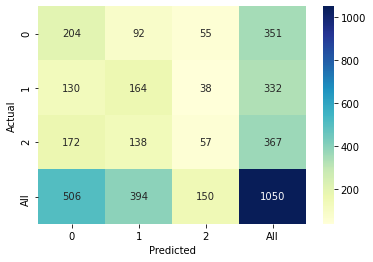

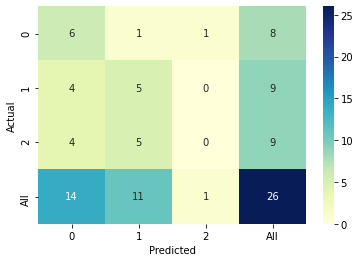

<Figure size 432x288 with 0 Axes>

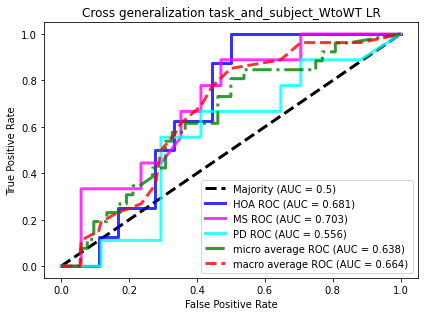

********************************
random_forest
best_params:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 25, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 40}

Stride-based model performance (mean):  [0.41116547422741023, 0.4111556245796912, 0.41116547422741023, 0.45604399482524033, [0.4214065317571629, 0.3501074800290487, 0.46195286195286195], 0.39987549771301123, 0.41116547422741023, 0.41116547422741023, [0.5725303300227466, 0.40417139188511675, 0.22292477123117038], 0.3749100987901096, 0.41116547422741023, 0.3937727871926967, [0.47891282458402784, 0.3731354460494807, 0.27268202573682027], 0.5947444925002731, 0.6056696205790735]

Stride-based model performance (standard deviation):  [0.11396616185577843, 0.08976064652398216, 0.11396616185577843, 0.11572462814838612, [0.2153409429159939, 0.23321584963232742, 0.3691547236763791], 0.10921902340477513, 0.113966

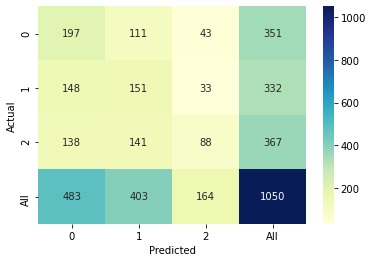

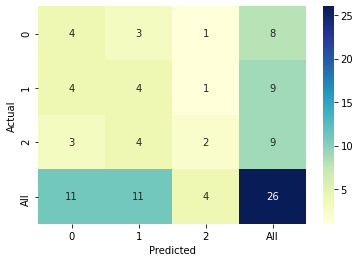

<Figure size 432x288 with 0 Axes>

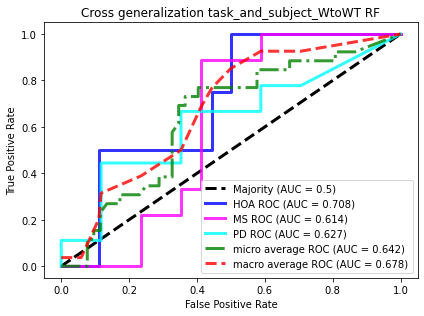

********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 2, 'adaboostclassifier__n_estimators': 75}

Stride-based model performance (mean):  [0.48698044253622597, 0.47138524827697303, 0.48698044253622597, 0.5081463935345316, [0.4917486251176107, 0.42473436960780026, 0.49767275010550804], 0.4707068225848907, 0.48698044253622597, 0.48698044253622597, [0.7496107689636506, 0.3170629831011479, 0.34544671568987373], 0.4300156112849999, 0.48698044253622597, 0.45660893212562303, [0.5841669623029592, 0.33975270660171236, 0.36612716495032827], 0.6404281240714969, 0.6436897783829278]

Stride-based model performance (standard deviation):  [0.1017514497099595, 0.0948457117372788, 0.1017514497099595, 0.10691694688580236, [0.17560645954603318, 0.14205739478848034, 0.2691153854996959], 0.09469821783345772, 0.1017514497099595, 0.1017514497099595, [0.17771938851830066, 0.1779401252104626, 0.3122343908816444], 0.09064032158621285, 0.1017514497099595, 0.086937217970250

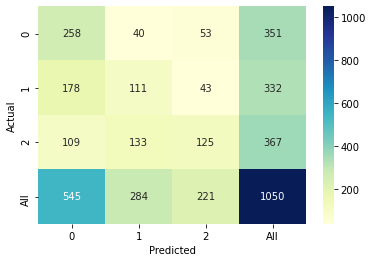

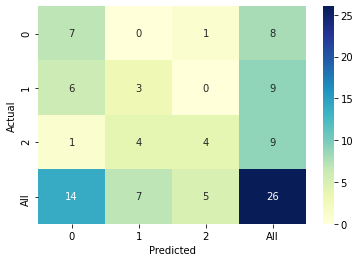

<Figure size 432x288 with 0 Axes>

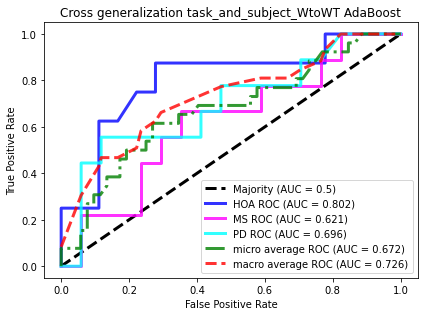

********************************
kernel_svm
best_params:  {'svc__gamma': 0.1}

Stride-based model performance (mean):  [0.4342983716219975, 0.4479107948579693, 0.4342983716219975, 0.48933599278726525, [0.41937213695395514, 0.36361950687921213, 0.5607407407407408], 0.4260941408554255, 0.4342983716219975, 0.4342983716219975, [0.6583467055357854, 0.3930520088539425, 0.22688370817654852], 0.3898001042681862, 0.4342983716219975, 0.40523744372461634, [0.5013596104188778, 0.37158734169642904, 0.29645336068925165], 0.5996089015924346, 0.6104549687207625]

Stride-based model performance (standard deviation):  [0.12827516685653767, 0.13455158220604355, 0.12827516685653767, 0.14398569231276925, [0.18284948199259457, 0.22943252796513836, 0.36505068517054484], 0.12020672345537022, 0.12827516685653767, 0.12827516685653767, [0.23890091469195412, 0.280277483647968, 0.21119944855299158], 0.13778557728580398, 0.12827516685653767, 0.1276967666489496, [0.1971404891926951, 0.24711256386534208, 0.2499182166

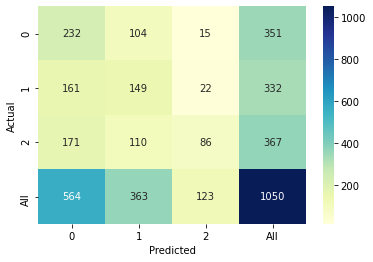

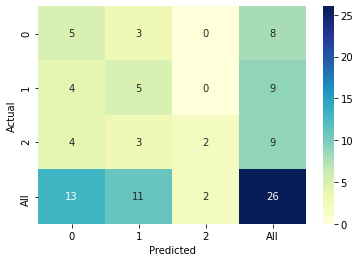

<Figure size 432x288 with 0 Axes>

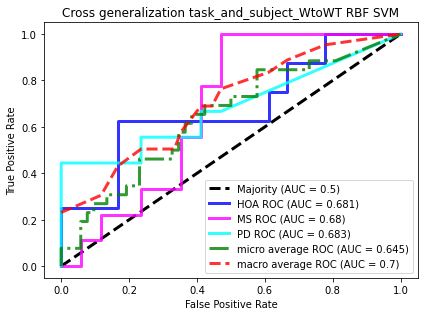

********************************
gbm
best_params:  {'gradientboostingclassifier__learning_rate': 0.15, 'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__max_features': 'auto', 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 4, 'gradientboostingclassifier__n_estimators': 100}

Stride-based model performance (mean):  [0.4460703779858825, 0.4533295689542321, 0.4460703779858825, 0.4907925912345347, [0.46462478311162525, 0.39860401699116416, 0.4967599067599068], 0.43527744523501066, 0.4460703779858825, 0.4460703779858825, [0.6122561597485763, 0.4390669787445018, 0.254509197211954], 0.4120238562000266, 0.4460703779858825, 0.43126528327795083, [0.5181970827517981, 0.40158867105552787, 0.3162858147927537], 0.6228259992216401, 0.632128413401353]

Stride-based model performance (standard deviation):  [0.10343956607237278, 0.0670673548529937, 0.10343956607237278, 0.06149697761682213, [0.22805316196579478, 0.202161284868758

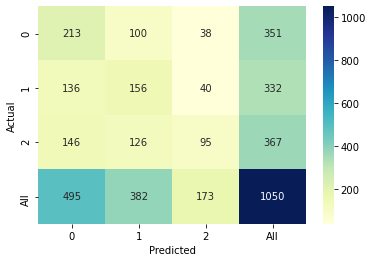

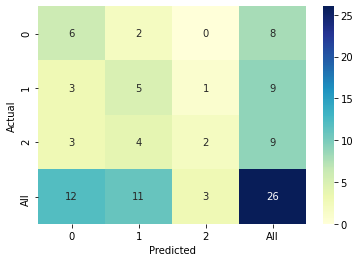

<Figure size 432x288 with 0 Axes>

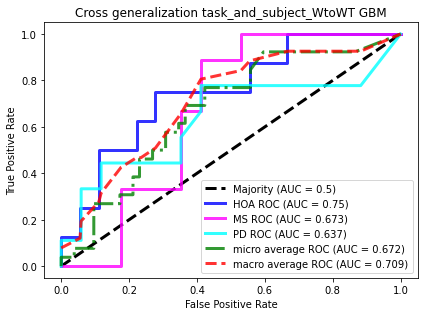

********************************
xgboost
best_params:  {'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__subsample': 0.8}

Stride-based model performance (mean):  [0.4377110887775367, 0.4403456203240538, 0.4377110887775367, 0.47556336073540484, [0.434955843712469, 0.37976970681175953, 0.5063113104479329], 0.4244734228485837, 0.4377110887775367, 0.4377110887775367, [0.6103855834088392, 0.41367887009089827, 0.24935581504601367], 0.40124199352714135, 0.4377110887775367, 0.4210597937665056, [0.4991720737580746, 0.383739942273773, 0.32081396454957667], 0.6217354014261028, 0.6316262098350822]

Stride-based model performance (standard deviation):  [0.10606288843037551, 0.07606839802964632, 0.10606288843037551, 0.06404061921975193, [0.20609976864510687, 0.2118043168071118, 0.2474323332143103], 0.10814250417130522, 0.10606288843037551, 0.10606288843037551, [0.2595264955094821, 0.281603082108

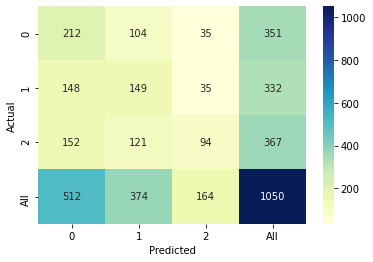

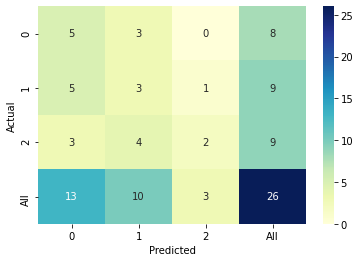

<Figure size 432x288 with 0 Axes>

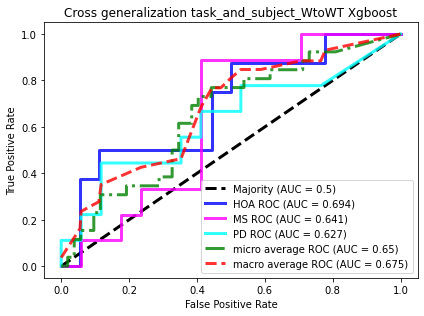

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 18}

Stride-based model performance (mean):  [0.4171913685469879, 0.40466541827071767, 0.4171913685469879, 0.4408821496169494, [0.4331881990750845, 0.3458135424216687, 0.43499451331539973], 0.40574726128554434, 0.4171913685469879, 0.4171913685469879, [0.6089346155473556, 0.33542073368521325, 0.2728864346240641], 0.3838077210245704, 0.4171913685469879, 0.4055210090580495, [0.49748321084751224, 0.33381357830905267, 0.32012637391714627], 0.5302207214968231, 0.5367788598682557]

Stride-based model performance (standard deviation):  [0.07996347722543755, 0.09363687838195052, 0.07996347722543755, 0.10505386219492567, [0.16693172490373095, 0.1978665869676691, 0.28323941715608597], 0.08280318444093848, 0.07996347722543755, 0.07996347722543755, [0.134632212226805, 0.18959809223244903, 0.20998434113419503], 0.09361692846008961, 0.07996347722543755, 0.08842263829325152, [0.14996545221359625,

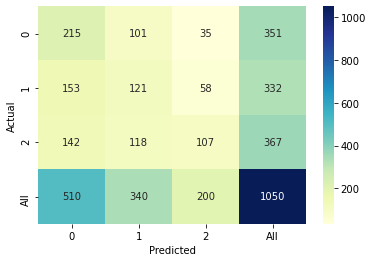

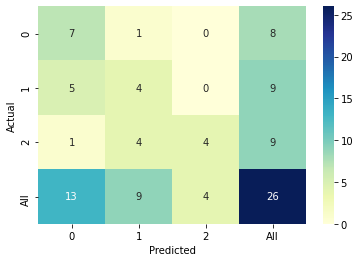

<Figure size 432x288 with 0 Axes>

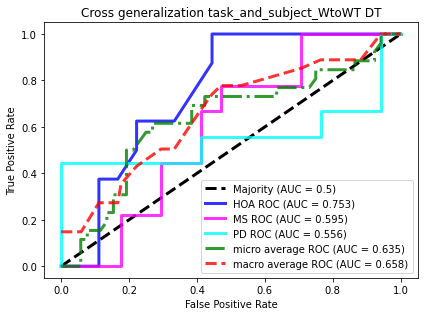

********************************
linear_svm
best_params:  {'svc__gamma': 0.0001}

Stride-based model performance (mean):  [0.415514181227881, 0.4347119996621108, 0.415514181227881, 0.4682503994620518, [0.4540178799489144, 0.46305260707795065, 0.3870655119594674], 0.41040028832891834, 0.415514181227881, 0.415514181227881, [0.5263096514764867, 0.568085049243755, 0.13680616426651349], 0.377693551724315, 0.415514181227881, 0.38949036259859693, [0.471313386475145, 0.4722408908519771, 0.189526377845823], 0.6405586245292331, 0.6468788510803176]

Stride-based model performance (standard deviation):  [0.11527774557341017, 0.06197514023839247, 0.11527774557341017, 0.036574820429254244, [0.2515432709038147, 0.20254960596565774, 0.16937147739673664], 0.0896082435991786, 0.11527774557341017, 0.11527774557341017, [0.23686008088524146, 0.2348925945274355, 0.053448262180120526], 0.10398875117806615, 0.11527774557341017, 0.1139075816869008, [0.2221183629221494, 0.19470772303038167, 0.044876874801747554

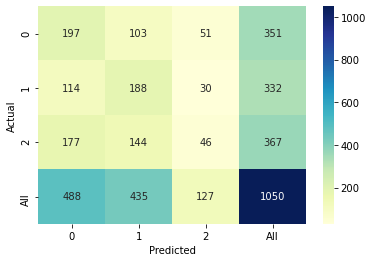

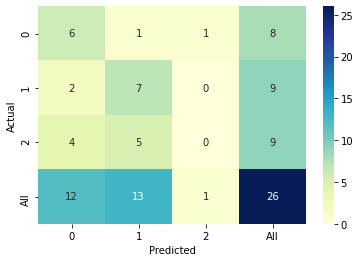

<Figure size 432x288 with 0 Axes>

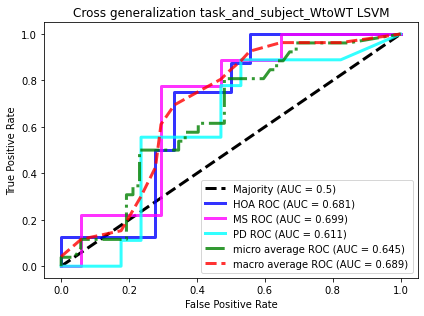

********************************
mlp
best_params:  {'mlpclassifier__hidden_layer_sizes': (50, 50, 50, 10, 50, 150, 30, 150, 5)}

Stride-based model performance (mean):  [0.47545894114392884, 0.4673392817670637, 0.47545894114392884, 0.5060941583617766, [0.46522320422702823, 0.38552973259504786, 0.5512649084791149], 0.46154962140860967, 0.47545894114392884, 0.47545894114392884, [0.5220008695943984, 0.397048114449572, 0.46559988018185844], 0.4376046401218642, 0.47545894114392884, 0.4609938598600597, [0.4843633919473906, 0.36779829587786445, 0.4606522325403376], 0.6120056187201592, 0.6213872922674281]

Stride-based model performance (standard deviation):  [0.09503092804660886, 0.08752054332257848, 0.09503092804660886, 0.10312783360975446, [0.18174610717929843, 0.22765145988981172, 0.30761907672412603], 0.0856864000805348, 0.09503092804660886, 0.09503092804660886, [0.1391504786796227, 0.2743925478924544, 0.33918018897677193], 0.08807820197151026, 0.09503092804660886, 0.08642555149804859, [0

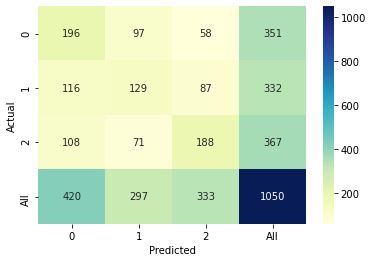

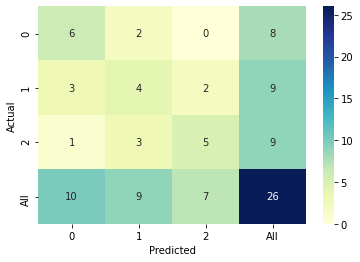

<Figure size 432x288 with 0 Axes>

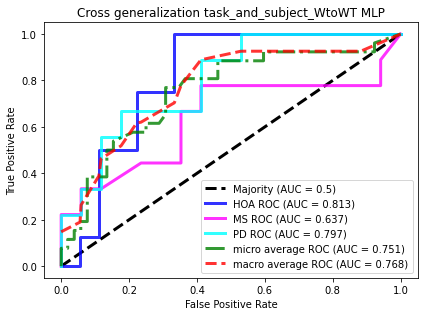

********************************
********************************
feet+ankle
logistic_regression
best_params:  {'logisticregression__random_state': 0}

Stride-based model performance (mean):  [0.4067019545034311, 0.42194332575975607, 0.4067019545034311, 0.4615706631012092, [0.4106885940649152, 0.4260683010134764, 0.4290730822008765], 0.399698142660324, 0.4067019545034311, 0.4067019545034311, [0.4804192583060126, 0.47790932122411556, 0.2407658484508437], 0.3821947625245776, 0.4067019545034311, 0.39745657400769413, [0.43572743244014306, 0.4249054344248852, 0.28595142070870455], 0.6199718331392875, 0.6280208153142125]

Stride-based model performance (standard deviation):  [0.10550916843269896, 0.0578569586747444, 0.10550916843269896, 0.06318776800904204, [0.19180281675803892, 0.20663841675332445, 0.255189123142788], 0.09335130622139137, 0.10550916843269896, 0.10550916843269896, [0.16432534626609244, 0.23197040280427317, 0.17143237747974627], 0.09586558018900082, 0.10550916843269896, 0.091

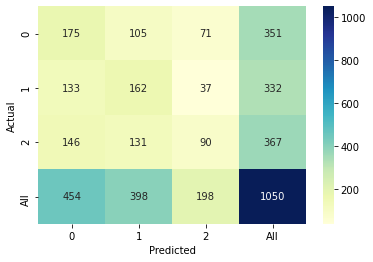

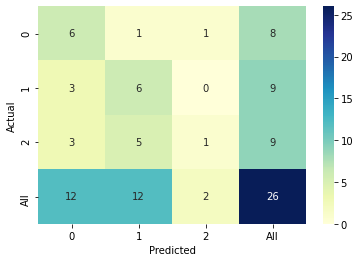

<Figure size 432x288 with 0 Axes>

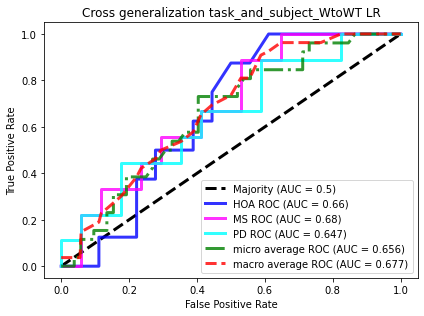

********************************
random_forest
best_params:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 50}

Stride-based model performance (mean):  [0.4130042711974623, 0.41646356943719776, 0.4130042711974623, 0.46053550924781217, [0.41137261682600934, 0.34297499885735183, 0.49504309262823193], 0.4059453436739826, 0.4130042711974623, 0.4130042711974623, [0.5615959829407756, 0.38888958196650936, 0.26735046611466284], 0.3793853216609711, 0.4130042711974623, 0.39569285158914874, [0.4655319821633637, 0.36052062826771397, 0.3121033545518356], 0.5877325503532578, 0.5983025389978697]

Stride-based model performance (standard deviation):  [0.11679907211876532, 0.08858456046465953, 0.11679907211876532, 0.11497951278439933, [0.2257516183487423, 0.21774688790836297, 0.3347397896845427], 0.1140969906407397, 0.1167990721

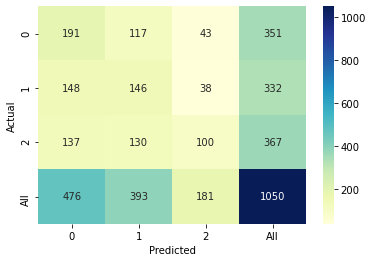

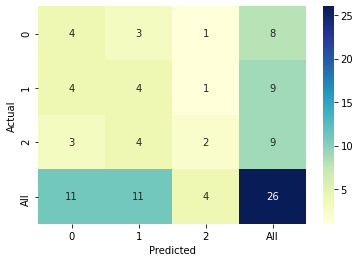

<Figure size 432x288 with 0 Axes>

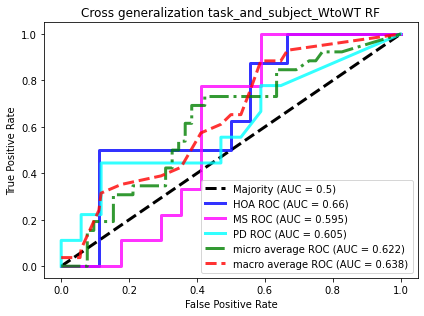

********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 1, 'adaboostclassifier__n_estimators': 150}

Stride-based model performance (mean):  [0.4269676027038619, 0.44140827708334623, 0.4269676027038619, 0.4735442776823298, [0.4605948642302413, 0.3584082584082584, 0.5052217086115391], 0.42245326556004725, 0.4269676027038619, 0.4269676027038619, [0.49972136502975734, 0.4423172650999189, 0.3253211665504656], 0.4037935731172502, 0.4269676027038619, 0.4183359910303749, [0.46571624751200624, 0.388564838635893, 0.3570996332038515], 0.5937705479003867, 0.5999240092967459]

Stride-based model performance (standard deviation):  [0.1338875974448076, 0.11634159295575355, 0.1338875974448076, 0.08904891575492833, [0.25674558517578344, 0.209856966726751, 0.17599379344773014], 0.154059259856163, 0.1338875974448076, 0.1338875974448076, [0.24263693618800652, 0.2727040314296752, 0.29335385904669725], 0.13760631913465052, 0.1338875974448076, 0.11033842710481943, [0.23

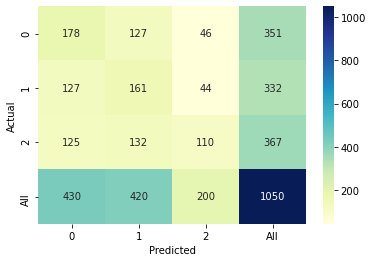

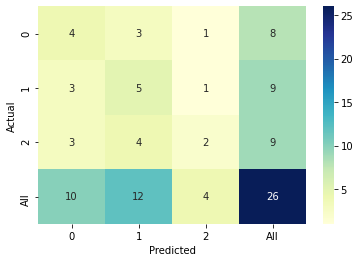

<Figure size 432x288 with 0 Axes>

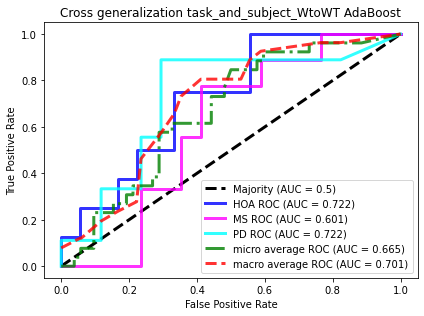

********************************
kernel_svm
best_params:  {'svc__gamma': 0.1}

Stride-based model performance (mean):  [0.4159121203440318, 0.4518292821582909, 0.4159121203440318, 0.4894932039894466, [0.396536884054362, 0.3512662333564713, 0.6076847290640394], 0.4084700804630067, 0.4159121203440318, 0.4159121203440318, [0.689162621447758, 0.35620117416709324, 0.18004644577416878], 0.3658763384690629, 0.4159121203440318, 0.379610384780932, [0.4921575908282406, 0.3480889789177567, 0.2573824456611913], 0.5893909118584789, 0.5991988984462029]

Stride-based model performance (standard deviation):  [0.11802956806173137, 0.1359978466061569, 0.11802956806173137, 0.13988725423564746, [0.16316539271844177, 0.2201854334379059, 0.37019460257659736], 0.11041583607632369, 0.11802956806173137, 0.11802956806173137, [0.23641648280795555, 0.2610612770879408, 0.18032614342904915], 0.12886845232298266, 0.11802956806173136, 0.11622851417125135, [0.18204863431691898, 0.2371199603520971, 0.22519901516311572]

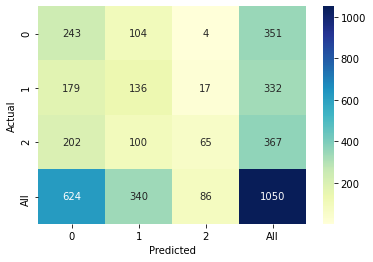

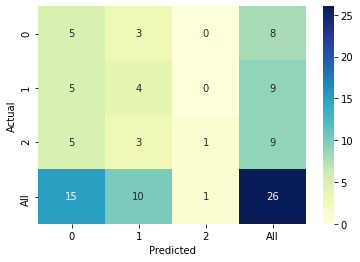

<Figure size 432x288 with 0 Axes>

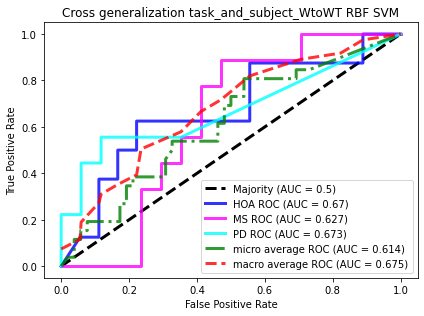

********************************
gbm
best_params:  {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassifier__max_features': 'auto', 'gradientboostingclassifier__min_samples_leaf': 3, 'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__n_estimators': 100}

Stride-based model performance (mean):  [0.4306359011814303, 0.42354320689967545, 0.4306359011814303, 0.4593411928755259, [0.4392888318565972, 0.3483223693534215, 0.4830184194890077], 0.4194511456892914, 0.4306359011814303, 0.4306359011814303, [0.5899277477942797, 0.4116796485029377, 0.25674604077065677], 0.39569138909382995, 0.4306359011814303, 0.4145422692931945, [0.494971302757591, 0.3712046772459465, 0.3208981872779524], 0.5887933019582251, 0.5977249800939968]

Stride-based model performance (standard deviation):  [0.09585837414045874, 0.06932913480453974, 0.09585837414045874, 0.06980945075182271, [0.21265264039185525, 0.2003419924947424

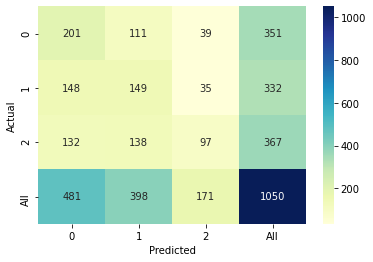

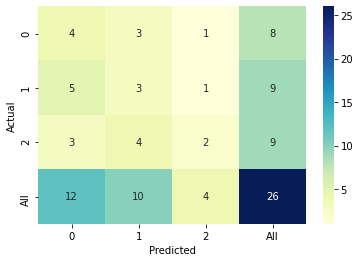

<Figure size 432x288 with 0 Axes>

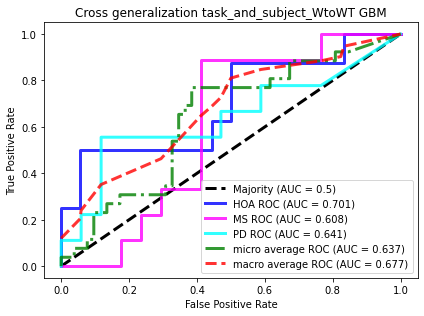

********************************
xgboost
best_params:  {'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__max_depth': 8, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__subsample': 0.8}

Stride-based model performance (mean):  [0.433281403826933, 0.42899461553949647, 0.433281403826933, 0.4602094609521387, [0.4261157959842178, 0.36382632112195384, 0.49704172951231773], 0.4228652498216897, 0.433281403826933, 0.433281403826933, [0.5725274994637988, 0.4108011380668247, 0.2852671119344457], 0.4022022724737323, 0.433281403826933, 0.41935720303729507, [0.4795133409886944, 0.3786838227501159, 0.3484096536823867], 0.5961043720381349, 0.6046666108652347]

Stride-based model performance (standard deviation):  [0.1054872988574572, 0.0938526521662803, 0.1054872988574572, 0.07712268335329425, [0.20274735841733035, 0.20213040162164525, 0.27148937127424083], 0.11469699861703801, 0.1054872988574572, 0.1054872988574572, [0.2586720354830843, 0.2660112807425822, 0.

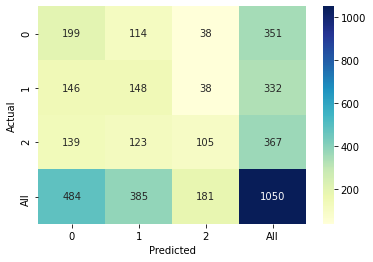

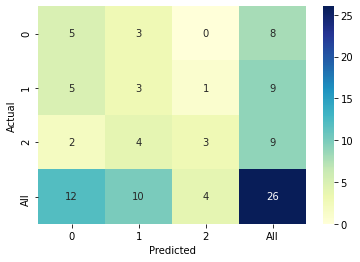

<Figure size 432x288 with 0 Axes>

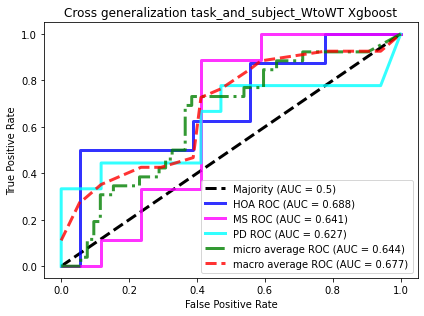

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 36}

Stride-based model performance (mean):  [0.39755007396516834, 0.3976940928035907, 0.39755007396516834, 0.43746618736892995, [0.39553293883903035, 0.356094071675796, 0.44145526789594586], 0.3905318862071164, 0.39755007396516834, 0.39755007396516834, [0.5784450893449883, 0.37218908717013455, 0.22096148210622618], 0.36606539256108167, 0.39755007396516834, 0.38231373837637456, [0.46137274847421655, 0.36115589129085107, 0.27566753791817733], 0.5340784810784045, 0.5414786849108546]

Stride-based model performance (standard deviation):  [0.09054312851111658, 0.08524650530097332, 0.09054312851111658, 0.12031576372208336, [0.18949562390199465, 0.1603500727687089, 0.344651843181206], 0.0836152192472138, 0.09054312851111658, 0.09054312851111658, [0.21443799036101066, 0.15932321896597387, 0.1859555345219523], 0.09138353885650266, 0.09054312851111658, 0.08537696951223932, [0.2006400079211

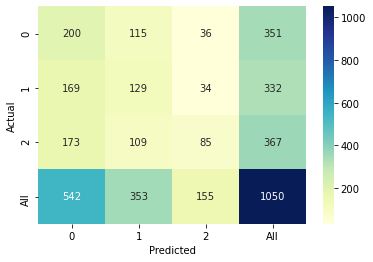

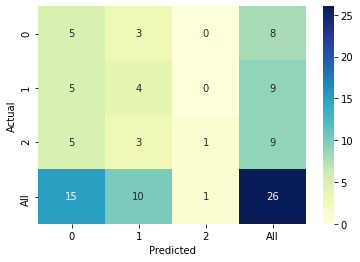

<Figure size 432x288 with 0 Axes>

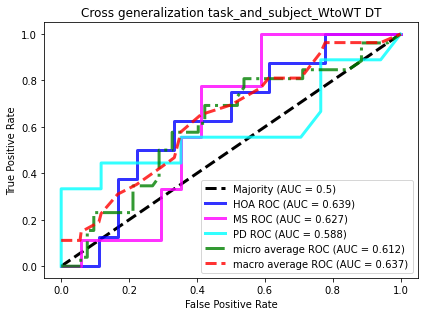

********************************
linear_svm
best_params:  {'svc__gamma': 0.0001}

Stride-based model performance (mean):  [0.4053264391246344, 0.4207977373405048, 0.4053264391246344, 0.4491214193300158, [0.4441977428523016, 0.3986438889664696, 0.41955158020274297], 0.4112953402237346, 0.4053264391246344, 0.4053264391246344, [0.500451853505443, 0.49186009856662594, 0.2415740685991349], 0.38169188402802884, 0.4053264391246344, 0.3828193908158269, [0.4600075891820099, 0.41415576684880995, 0.2709122960532666], 0.6168923191371907, 0.6220365595953337]

Stride-based model performance (standard deviation):  [0.13130905524257216, 0.08498393333278369, 0.13130905524257216, 0.07250925921535986, [0.20346643875123435, 0.18336112433136587, 0.22718532078719192], 0.10520566406118198, 0.13130905524257216, 0.13130905524257216, [0.14804978600332303, 0.2595734047982156, 0.23482254145749407], 0.1211003962523467, 0.13130905524257216, 0.13250285586486524, [0.17640912865588645, 0.20724645562973115, 0.222139042

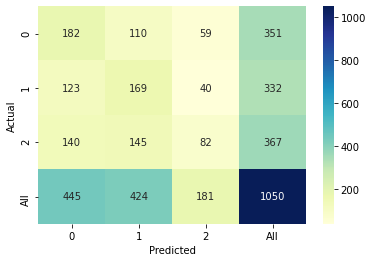

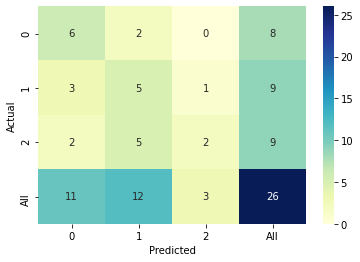

<Figure size 432x288 with 0 Axes>

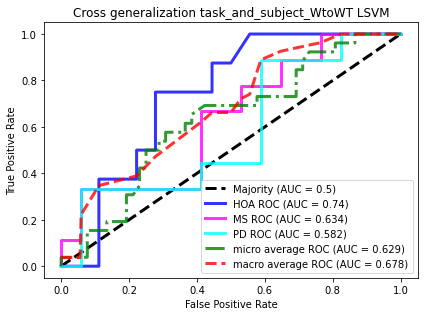

********************************
mlp
best_params:  {'mlpclassifier__hidden_layer_sizes': (50, 50, 50, 10, 50, 10, 150, 60, 150)}

Stride-based model performance (mean):  [0.4521017560660711, 0.44872493521774315, 0.4521017560660711, 0.48165198386499714, [0.44082252124605364, 0.41990225104047585, 0.48545003336670006], 0.44319550101987676, 0.4521017560660711, 0.4521017560660711, [0.5102973545946246, 0.47901111709526456, 0.340278031369741], 0.43147101344772487, 0.4521017560660711, 0.44902127509546325, [0.4659906384898905, 0.43960282241688853, 0.3888195794363959], 0.6094344406843837, 0.6169426757820885]

Stride-based model performance (standard deviation):  [0.11240812271441071, 0.11760042984318685, 0.11240812271441071, 0.11760610638587185, [0.16909239699751402, 0.20414228300488219, 0.3179914160350948], 0.11371599240056034, 0.11240812271441071, 0.11240812271441071, [0.1486448513850062, 0.2435522452898612, 0.2548748227004303], 0.12115278007764756, 0.11240812271441071, 0.1097446067545554, [0.

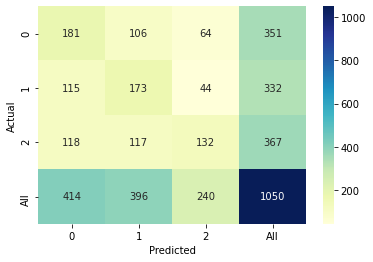

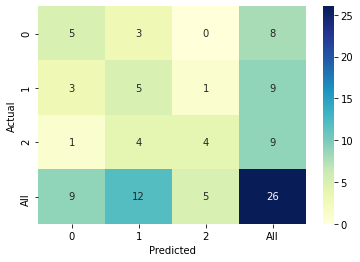

<Figure size 432x288 with 0 Axes>

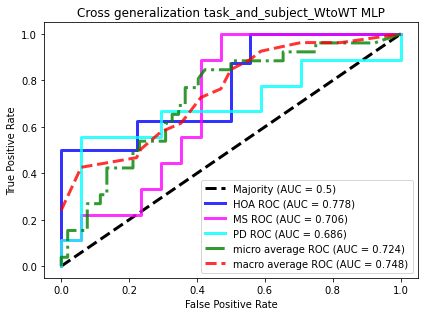

********************************
********************************
feet+ankle+knee
logistic_regression
best_params:  {'logisticregression__random_state': 0}

Stride-based model performance (mean):  [0.4349448220633619, 0.45794446512773146, 0.4349448220633619, 0.488088477691595, [0.42662449139366876, 0.40693775108858765, 0.540271152900938], 0.43364510164755055, 0.4349448220633619, 0.4349448220633619, [0.463041129188753, 0.47373429000998324, 0.3641598857439154], 0.4235570292110782, 0.4349448220633619, 0.43560804748201, [0.4301609551385752, 0.4218041628988122, 0.4187059695958472], 0.6257466612860318, 0.6319279460455226]

Stride-based model performance (standard deviation):  [0.09466187551224346, 0.0769819471509722, 0.09466187551224346, 0.08850649540084467, [0.20312990255086533, 0.14263507872131137, 0.1940702759702539], 0.09674074973183613, 0.09466187551224346, 0.09466187551224346, [0.11105750204634866, 0.23583393709225997, 0.16187375405854573], 0.09836365644931089, 0.09466187551224346, 0.0

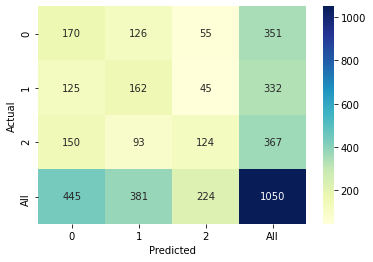

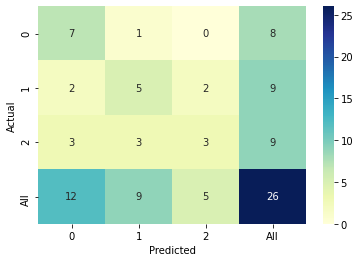

<Figure size 432x288 with 0 Axes>

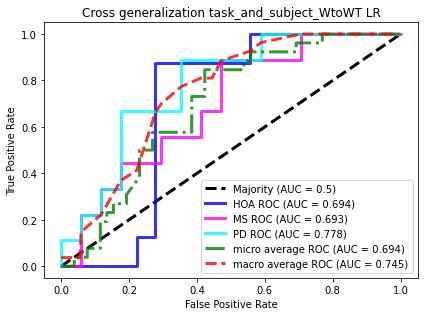

********************************
random_forest
best_params:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 50}

Stride-based model performance (mean):  [0.4177097294283512, 0.417049859563145, 0.4177097294283512, 0.4599259569203603, [0.4200488824879098, 0.37111068621151516, 0.45999000999001], 0.40736419135959706, 0.4177097294283512, 0.4177097294283512, [0.5254611841366139, 0.45838100771320917, 0.2382503822289683], 0.38873545458204267, 0.4177097294283512, 0.4079383913009706, [0.4606916539506055, 0.4079245153776802, 0.2975901944178423], 0.6183597920382438, 0.6281223699891172]

Stride-based model performance (standard deviation):  [0.10987140988727656, 0.08442952761172749, 0.10987140988727656, 0.11441512086858288, [0.25640959006274927, 0.20395888112464328, 0.34791340092433276], 0.11056245294663682, 0.109871409887276

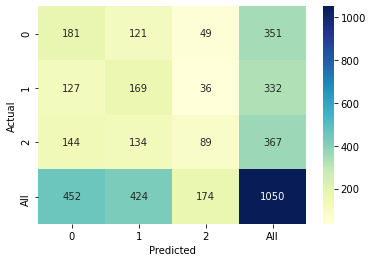

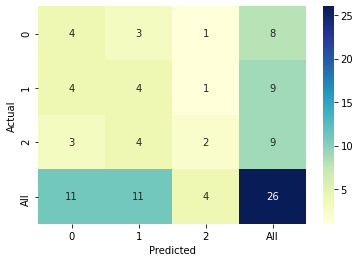

<Figure size 432x288 with 0 Axes>

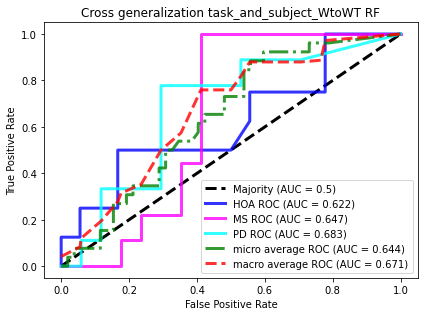

********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 1, 'adaboostclassifier__n_estimators': 75}

Stride-based model performance (mean):  [0.4514158983088433, 0.4695615059513674, 0.4514158983088433, 0.5121961502922966, [0.4417459231514959, 0.39273001271908836, 0.5742085819835181], 0.4470333153885521, 0.4514158983088433, 0.4514158983088433, [0.4779096322170134, 0.3774495174958838, 0.48574079645275925], 0.43776632973289775, 0.4514158983088433, 0.45781560481542893, [0.455396104049419, 0.3743906624557214, 0.483512222693553], 0.6745869045780878, 0.6808291305954645]

Stride-based model performance (standard deviation):  [0.14780755510179053, 0.12834957512588885, 0.14780755510179053, 0.12263210202802215, [0.299337381296875, 0.26195706081627235, 0.19770336105393407], 0.17563203577522293, 0.14780755510179053, 0.14780755510179053, [0.26767166169324147, 0.21692778744228336, 0.31586509313176336], 0.15381917162497472, 0.14780755510179053, 0.12900464065735565,

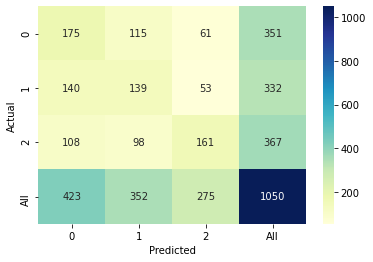

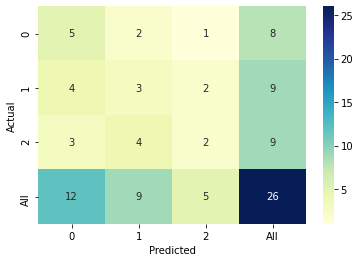

<Figure size 432x288 with 0 Axes>

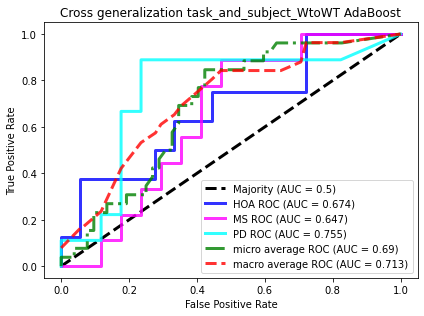

********************************
kernel_svm
best_params:  {'svc__gamma': 0.1}

Stride-based model performance (mean):  [0.41613876567937275, 0.4905309689441449, 0.41613876567937275, 0.5262858102101644, [0.3926187372293492, 0.34786305849197446, 0.7311111111111112], 0.4104226969841185, 0.41613876567937275, 0.41613876567937275, [0.7614012871747957, 0.308055197662156, 0.16181160611540357], 0.35215117258276357, 0.41613876567937275, 0.364387146697252, [0.5055745937017055, 0.32179761228705894, 0.2290813117595263], 0.6221518918809454, 0.6300388137519377]

Stride-based model performance (standard deviation):  [0.1378528869596508, 0.18518692949291862, 0.1378528869596508, 0.17989406206187777, [0.17072761533665617, 0.25343476232036966, 0.4199059271483566], 0.12342155702435262, 0.1378528869596508, 0.1378528869596508, [0.2097837940464745, 0.26240657396752465, 0.2019110501935325], 0.15709512433897913, 0.13785288695965078, 0.150933617919183, [0.18225065902061838, 0.2613357884563889, 0.2419960498056431

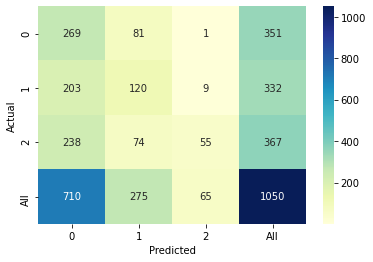

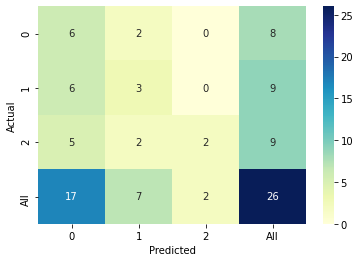

<Figure size 432x288 with 0 Axes>

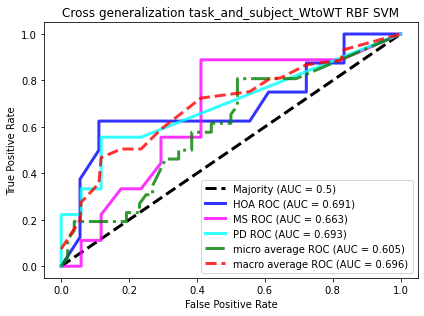

********************************
gbm
best_params:  {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__max_features': 'auto', 'gradientboostingclassifier__min_samples_leaf': 3, 'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__n_estimators': 150}

Stride-based model performance (mean):  [0.46182554380872676, 0.47195068946823016, 0.46182554380872676, 0.5065293166907042, [0.4523768867271343, 0.391507979954257, 0.5719672017232993], 0.45236292726467, 0.46182554380872676, 0.46182554380872676, [0.5606349789969608, 0.4284052530579008, 0.36804854973914863], 0.44054995336526226, 0.46182554380872676, 0.45815346178152366, [0.4900698340543592, 0.40021337411750013, 0.4313666519239275], 0.6408989035000823, 0.6501373296770139]

Stride-based model performance (standard deviation):  [0.14949657771695657, 0.1324533850435598, 0.14949657771695657, 0.12506541380539055, [0.26726535141485275, 0.181424557874

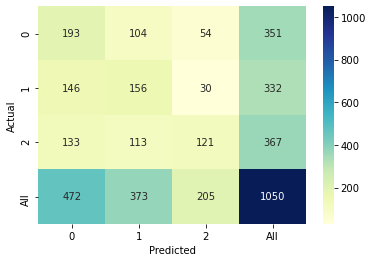

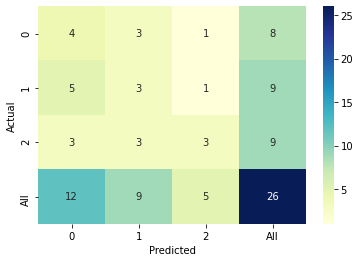

<Figure size 432x288 with 0 Axes>

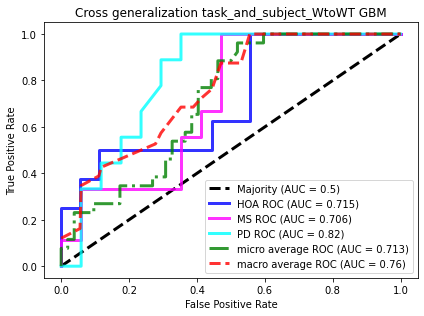

********************************
xgboost
best_params:  {'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 2, 'xgbclassifier__max_depth': 8, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__subsample': 1.0}

Stride-based model performance (mean):  [0.45879612465133385, 0.46814487011322325, 0.45879612465133385, 0.5040574790901233, [0.4358164554500521, 0.4083733867378727, 0.560244768151745], 0.4495710239168426, 0.45879612465133385, 0.45879612465133385, [0.5393856811652564, 0.45566023420635227, 0.35366715637891905], 0.436696555557889, 0.45879612465133385, 0.4550059838555923, [0.4716851702350469, 0.42476189111395896, 0.4136426053246611], 0.6261023843599864, 0.6336022639471389]

Stride-based model performance (standard deviation):  [0.1235202164374321, 0.10717871366481993, 0.1235202164374321, 0.11032607058865292, [0.23990754906784428, 0.15579834146665095, 0.2620290513493656], 0.1322944741734204, 0.1235202164374321, 0.1235202164374321, [0.2655118073062575, 0.209926623346823

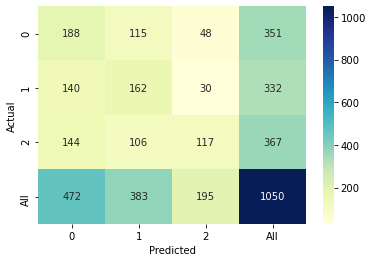

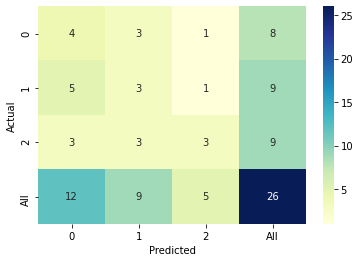

<Figure size 432x288 with 0 Axes>

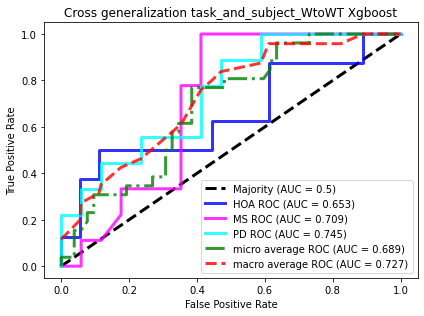

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 44}

Stride-based model performance (mean):  [0.42657993861029136, 0.4398362872967592, 0.42657993861029136, 0.47179948745389916, [0.3969293489829807, 0.3784413007164645, 0.5441382121908326], 0.4220230864017974, 0.42657993861029136, 0.42657993861029136, [0.5415837415028517, 0.35311471109382936, 0.37137080660871125], 0.4115074804002548, 0.42657993861029136, 0.427699061255378, [0.44910489078229154, 0.3641599777333183, 0.4212575726851546], 0.5712273535856436, 0.5763341347751302]

Stride-based model performance (standard deviation):  [0.08344140325367426, 0.07090548470143906, 0.08344140325367426, 0.0885699518027516, [0.1888034956681607, 0.14742758597931113, 0.18224733739791388], 0.09374949975631347, 0.08344140325367426, 0.08344140325367426, [0.20436540536278258, 0.13639763254292764, 0.19510089167461786], 0.08796304244548914, 0.08344140325367426, 0.07672305643149256, [0.1923061853568549

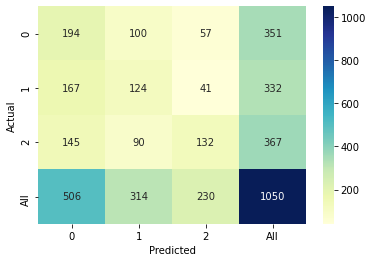

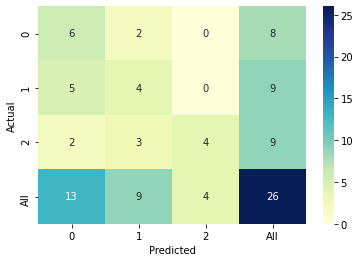

<Figure size 432x288 with 0 Axes>

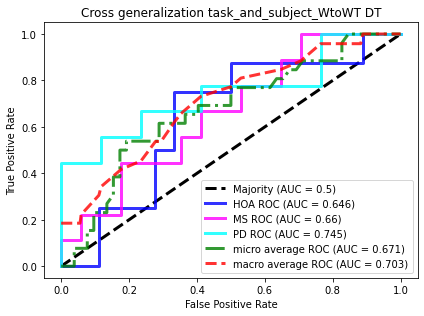

********************************
linear_svm
best_params:  {'svc__gamma': 0.0001}

Stride-based model performance (mean):  [0.44563514850840524, 0.4684502406095644, 0.44563514850840524, 0.49819298671273027, [0.4644885423061179, 0.41824903506261457, 0.522613144459961], 0.4483514178923606, 0.44563514850840524, 0.44563514850840524, [0.5041680710032581, 0.46882151596513866, 0.3720646667086853], 0.43217726196225226, 0.44563514850840524, 0.4412031476329843, [0.46749789460990965, 0.4231456189311857, 0.4058882723456613], 0.6328596726230185, 0.6380656654507864]

Stride-based model performance (standard deviation):  [0.13318519140246754, 0.1067456752286928, 0.13318519140246754, 0.10164818834074517, [0.24594583378667614, 0.17250326098286506, 0.1757141510351541], 0.1366113321390769, 0.13318519140246754, 0.13318519140246754, [0.14560183532689538, 0.2544911977175853, 0.2516310573635198], 0.13772794322175305, 0.13318519140246754, 0.12936504893805714, [0.19325510967298629, 0.19986700387762338, 0.186324

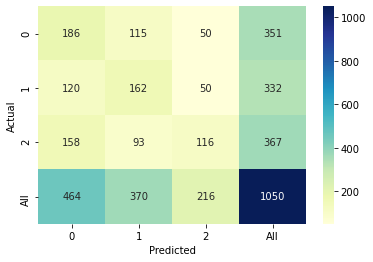

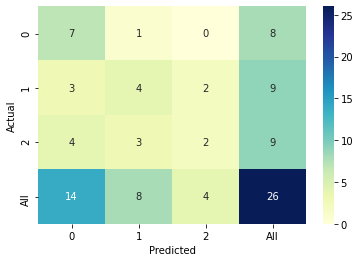

<Figure size 432x288 with 0 Axes>

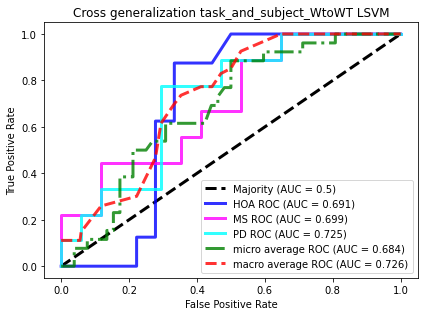

********************************
mlp
best_params:  {'mlpclassifier__hidden_layer_sizes': (128, 8, 8, 128, 32)}

Stride-based model performance (mean):  [0.49641835953977054, 0.49893745627950803, 0.49641835953977054, 0.5319216767192091, [0.4985621189226703, 0.4400053080592968, 0.558244941856557], 0.4998110797656133, 0.49641835953977054, 0.49641835953977054, [0.4715009695393922, 0.5202134538257933, 0.5077188159316542], 0.47656677834218913, 0.49641835953977054, 0.4870482729577018, [0.460802778196405, 0.4618488956558233, 0.5070486611743392], 0.6780285724791792, 0.6820208675263687]

Stride-based model performance (standard deviation):  [0.09298169210636999, 0.10532147990684736, 0.09298169210636999, 0.10972165273528516, [0.29758125030087296, 0.11172860818001511, 0.26277942881026334], 0.10194759985779654, 0.09298169210636999, 0.09298169210636999, [0.2674498046333778, 0.22724668905218856, 0.29002574596248704], 0.0993143449187589, 0.09298169210637001, 0.0835083344284837, [0.2522430182094785, 0.

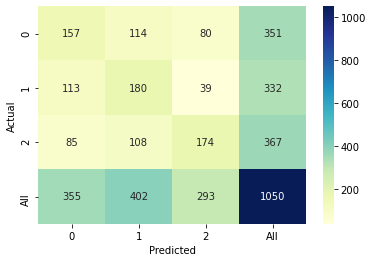

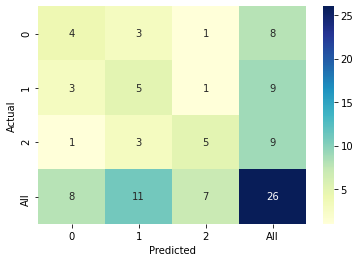

<Figure size 432x288 with 0 Axes>

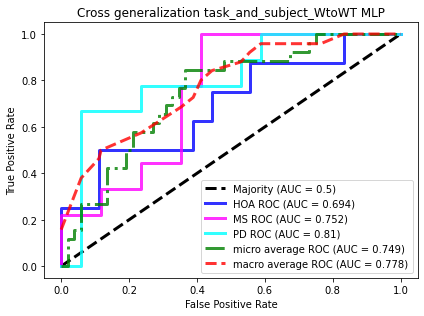

********************************
********************************


In [21]:
for col in datastreams:
    print (col)
    datastream = datastreams[col]
#     print (regressN_trainX_norm[datastream].head())
    stride_person_metrics = run_ml_models(ml_models, X_full[datastream], Y_full, train_indices, test_indices, framework, results_path, save_results, col)
    for i in stride_person_metrics.columns:
        metrics[(i, col)] = stride_person_metrics[i]
    print ('********************************')

if save_results:
    metrics.to_csv(results_path+ framework + '\\cross_generalize_ablation_study_'+framework+'_result_metrics.csv')

In [22]:
metrics

,"(logistic_regression, feet)","(logistic_regression, feet+ankle)","(logistic_regression, feet+ankle+knee)","(random_forest, feet)","(random_forest, feet+ankle)","(random_forest, feet+ankle+knee)","(adaboost, feet)","(adaboost, feet+ankle)","(adaboost, feet+ankle+knee)","(kernel_svm, feet)",...,"(xgboost, feet+ankle+knee)","(decision_tree, feet)","(decision_tree, feet+ankle)","(decision_tree, feet+ankle+knee)","(linear_svm, feet)","(linear_svm, feet+ankle)","(linear_svm, feet+ankle+knee)","(mlp, feet)","(mlp, feet+ankle)","(mlp, feet+ankle+knee)"
stride_accuracy_mean,0.409557,0.406702,0.434945,0.411165,0.413004,0.417710,0.486980,0.426968,0.451416,0.434298,...,0.458796,0.417191,0.397550,0.426580,0.415514,0.405326,0.445635,0.475459,0.452102,0.496418
stride_precision_macro_mean,0.426351,0.421943,0.457944,0.411156,0.416464,0.417050,0.471385,0.441408,0.469562,0.447911,...,0.468145,0.404665,0.397694,0.439836,0.434712,0.420798,0.468450,0.467339,0.448725,0.498937
stride_precision_micro_mean,0.409557,0.406702,0.434945,0.411165,0.413004,0.417710,0.486980,0.426968,0.451416,0.434298,...,0.458796,0.417191,0.397550,0.426580,0.415514,0.405326,0.445635,0.475459,0.452102,0.496418
stride_precision_weighted_mean,0.465198,0.461571,0.488088,0.456044,0.460536,0.459926,0.508146,0.473544,0.512196,0.489336,...,0.504057,0.440882,0.437466,0.471799,0.468250,0.449121,0.498193,0.506094,0.481652,0.531922
stride_precision_class_wise_mean,"[0.4592833668689175, 0.4409138759818266, 0.378...","[0.4106885940649152, 0.4260683010134764, 0.429...","[0.42662449139366876, 0.40693775108858765, 0.5...","[0.4214065317571629, 0.3501074800290487, 0.461...","[0.41137261682600934, 0.34297499885735183, 0.4...","[0.4200488824879098, 0.37111068621151516, 0.45...","[0.4917486251176107, 0.42473436960780026, 0.49...","[0.4605948642302413, 0.3584082584082584, 0.505...","[0.4417459231514959, 0.39273001271908836, 0.57...","[0.41937213695395514, 0.36361950687921213, 0.5...",...,"[0.4358164554500521, 0.4083733867378727, 0.560...","[0.4331881990750845, 0.3458135424216687, 0.434...","[0.39553293883903035, 0.356094071675796, 0.441...","[0.3969293489829807, 0.3784413007164645, 0.544...","[0.4540178799489144, 0.46305260707795065, 0.38...","[0.4441977428523016, 0.3986438889664696, 0.419...","[0.4644885423061179, 0.41824903506261457, 0.52...","[0.46522320422702823, 0.38552973259504786, 0.5...","[0.44082252124605364, 0.41990225104047585, 0.4...","[0.4985621189226703, 0.4400053080592968, 0.558..."
stride_recall_macro_mean,0.398213,0.399698,0.433645,0.399875,0.405945,0.407364,0.470707,0.422453,0.447033,0.426094,...,0.449571,0.405747,0.390532,0.422023,0.410400,0.411295,0.448351,0.461550,0.443196,0.499811
stride_recall_micro_mean,0.409557,0.406702,0.434945,0.411165,0.413004,0.417710,0.486980,0.426968,0.451416,0.434298,...,0.458796,0.417191,0.397550,0.426580,0.415514,0.405326,0.445635,0.475459,0.452102,0.496418
stride_recall_weighted_mean,0.409557,0.406702,0.434945,0.411165,0.413004,0.417710,0.486980,0.426968,0.451416,0.434298,...,0.458796,0.417191,0.397550,0.426580,0.415514,0.405326,0.445635,0.475459,0.452102,0.496418
stride_recall_class_wise_mean,"[0.5569025368519808, 0.48293876550560744, 0.15...","[0.4804192583060126, 0.47790932122411556, 0.24...","[0.463041129188753, 0.47373429000998324, 0.364...","[0.5725303300227466, 0.40417139188511675, 0.22...","[0.5615959829407756, 0.38888958196650936, 0.26...","[0.5254611841366139, 0.45838100771320917, 0.23...","[0.7496107689636506, 0.3170629831011479, 0.345...","[0.49972136502975734, 0.4423172650999189, 0.32...","[0.4779096322170134, 0.3774495174958838, 0.485...","[0.6583467055357854, 0.3930520088539425, 0.226...",...,"[0.5393856811652564, 0.45566023420635227, 0.35...","[0.6089346155473556, 0.33542073368521325, 0.27...","[0.5784450893449883, 0.37218908717013455, 0.22...","[0.5415837415028517, 0.35311471109382936, 0.37...","[0.5263096514764867, 0.568085049243755, 0.1368...","[0.500451853505443, 0.49186009856662594, 0.241...","[0.5041680710032581, 0.468821

### Reading the final metrics from the saved file

In [23]:
ablation_cross_generalize = pd.read_csv(results_path+ framework + '\\cross_generalize_ablation_study_'+framework+'_result_metrics.csv')
ablation_cross_generalize.index = ablation_cross_generalize['Unnamed: 0']
ablation_cross_generalize.drop('Unnamed: 0', axis = 1, inplace = True)

ablation_cross_generalize.columns = [literal_eval(ablation_cross_generalize.loc['person_accuracy_mean'].index[idx]) for idx in range(len(ablation_cross_generalize.loc['person_accuracy_mean'].index))]

In [24]:
ablation_cross_generalize

,"(logistic_regression, feet)","(logistic_regression, feet+ankle)","(logistic_regression, feet+ankle+knee)","(random_forest, feet)","(random_forest, feet+ankle)","(random_forest, feet+ankle+knee)","(adaboost, feet)","(adaboost, feet+ankle)","(adaboost, feet+ankle+knee)","(kernel_svm, feet)",...,"(xgboost, feet+ankle+knee)","(decision_tree, feet)","(decision_tree, feet+ankle)","(decision_tree, feet+ankle+knee)","(linear_svm, feet)","(linear_svm, feet+ankle)","(linear_svm, feet+ankle+knee)","(mlp, feet)","(mlp, feet+ankle)","(mlp, feet+ankle+knee)"
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
stride_accuracy_mean,0.4095568048152133,0.4067019545034311,0.4349448220633619,0.41116547422741023,0.4130042711974623,0.4177097294283512,0.48698044253622597,0.4269676027038619,0.4514158983088433,0.4342983716219975,...,0.45879612465133385,0.4171913685469879,0.39755007396516834,0.42657993861029136,0.415514181227881,0.4053264391246344,0.44563514850840524,0.47545894114392884,0.4521017560660711,0.49641835953977054
stride_precision_macro_mean,0.42635094585863464,0.42194332575975607,0.45794446512773146,0.4111556245796912,0.41646356943719776,0.417049859563145,0.47138524827697303,0.44140827708334623,0.4695615059513674,0.4479107948579693,...,0.46814487011322325,0.40466541827071767,0.3976940928035907,0.4398362872967592,0.4347119996621108,0.4207977373405048,0.4684502406095644,0.4673392817670637,0.44872493521774315,0.49893745627950803
stride_precision_micro_mean,0.4095568048152133,0.4067019545034311,0.4349448220633619,0.41116547422741023,0.4130042711974623,0.4177097294283512,0.48698044253622597,0.4269676027038619,0.4514158983088433,0.4342983716219975,...,0.45879612465133385,0.4171913685469879,0.39755007396516834,0.42657993861029136,0.415514181227881,0.4053264391246344,0.44563514850840524,0.47545894114392884,0.4521017560660711,0.49641835953977054
stride_precision_weighted_mean,0.4651980680835071,0.4615706631012092,0.488088477691595,0.45604399482524033,0.46053550924781217,0.4599259569203603,0.5081463935345316,0.4735442776823298,0.5121961502922966,0.48933599278726525,...,0.5040574790901233,0.4408821496169494,0.43746618736892995,0.47179948745389916,0.4682503994620518,0.4491214193300158,0.49819298671273027,0.5060941583617766,0.48165198386499714,0.5319216767192091
stride_precision_class_wise_mean,"[0.4592833668689175, 0.4409138759818266, 0.378...","[0.4106885940649152, 0.4260683010134764, 0.429...","[0.42662449139366876, 0.40693775108858765, 0.5...","[0.4214065317571629, 0.3501074800290487, 0.461...","[0.41137261682600934, 0.34297499885735183, 0.4...","[0.4200488824879098, 0.37111068621151516, 0.45...","[0.4917486251176107, 0.42473436960780026, 0.49...","[0.4605948642302413, 0.3584082584082584, 0.505...","[0.4417459231514959, 0.39273001271908836, 0.57...","[0.41937213695395514, 0.36361950687921213, 0.5...",...,"[0.4358164554500521, 0.4083733867378727, 0.560...","[0.4331881990750845, 0.3458135424216687, 0.434...","[0.39553293883903035, 0.356094071675796, 0.441...","[0.3969293489829807, 0.3784413007164645, 0.544...","[0.4540178799489144, 0.46305260707795065, 0.38...","[0.4441977428523016, 0.3986438889664696, 0.419...","[0.4644885423061179, 0.41824903506261457, 0.52...","[0.46522320422702823, 0.38552973259504786, 0.5...","[0.44082252124605364, 0.41990225104047585, 0.4...","[0.4985621189226703, 0.4400053080592968, 0.558..."
stride_recall_macro_mean,0.3982129129577138,0.399698142660324,0.43364510164755055,0.39987549771301123,0.4059453436739826,0.40736419135959706,0.4707068225848907,0.42245326556004725,0.4470333153885521,0.4260941408554255,...,0.4495710239168426,0.40574726128554434,0.3905318862071164,0.4220230864017974,0.41040028832891834,0.4112953402237346,0.4483514178923606,0.46154962140860967,0.44319550101987676,0.4998110797656133
stride_recall_micro_mean,0.4095568048152133,0.4067019545034311,0.4349448220633619,0.41116547422741023,0.4130042711974623,0.4177097294283512,0.48698044253622597,0.4269676027038619,0.4514158983088433,0.4342983716219975,...,0.45879612465133385,0.417191

### Heatmap for person mean accuracy for all algorithms and data streams for Cross generalize W->WT

In [25]:
person_accuracy_cross_generlaize = pd.DataFrame(columns = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp'], index = list(datastreams.keys()))


for idx in range(len(ablation_cross_generalize.columns)):
    x = ablation_cross_generalize.loc['person_accuracy_mean'].index[idx][1]
    y = ablation_cross_generalize.loc['person_accuracy_mean'].index[idx][0]
#     print (regressN_metrics.loc['person_accuracy'][(y, x)])
    person_accuracy_cross_generlaize.loc[x, y] = ablation_cross_generalize.loc['person_accuracy_mean'][(y, x)]

person_accuracy_cross_generlaize = person_accuracy_cross_generlaize.astype(float)

In [26]:
#Adding the person mean accuracy for all the models using all the features 
person_accuracy_cross_generlaize.loc['All features'] = [np.nan]*9

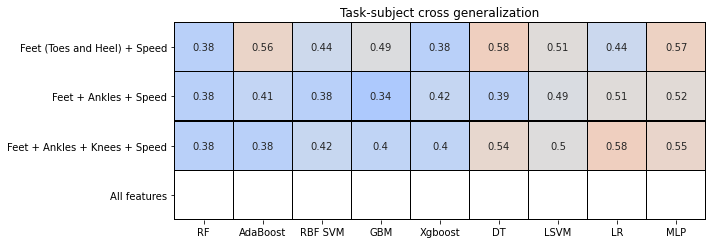

In [27]:
ml_model_names1 = ['RF','AdaBoost', 'RBF SVM', 'GBM','Xgboost', 'DT',  'LSVM', 'LR', 'MLP']
datasets = ['Feet (Toes and Heel) + Speed', 'Feet + Ankles + Speed', 'Feet + Ankles + Knees + Speed', 'All features']

fig, axes = plt.subplots(1, 1, figsize=(10, 3.5))
sns.heatmap(person_accuracy_cross_generlaize, vmin=0, vmax=1.0, center = 0.5, cmap="coolwarm", annot=True, linewidths=0.4, linecolor="k", \
            cbar = False, xticklabels=ml_model_names1,  yticklabels=datasets)
plt.title('Task-subject cross generalization')
plt.tight_layout()
plt.savefig(results_path + framework + '\\cross_generalize_ablation_study_'+framework+'_heatmap.jpg', dpi = 250)
plt.show()